## Preprocessing

In [ ]:
!pip install mne
!pip install pyentrp
! pip install hurst

In [ ]:
# Helper Functions

# Create trials from data

def create_trials(data ):
  boundary_frames = []
  for i in range(0 , len(data[61, :])):
    if (data[61 , i]!=0) and ((data[61, i-1] == 0) or (data[61,i+1]==0)):
      boundary_frames.append(i)
  
  Ecog_data = []
  Ecog_label = []
  Fingers_data = []
  for i in range(0 , len(boundary_frames) , 2):

    
      Ecog_data.append(data[1:61 , boundary_frames[i]-1000:boundary_frames[i+1]+1001] [: , 0:4400])
      Fingers_data.append( data[62: , boundary_frames[i]-1000:boundary_frames[i+1]+1001] [: , 0:4400])
      Ecog_label.append(data[61 , boundary_frames[i] ])

  return np.stack(Ecog_data) , Ecog_label , np.stack(Fingers_data)
#np.vstack([data[1:61,:] ,data[62: , :]]


def compute_accuracy(X, y, model ,threshold = 0.5):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """


  y_pred = model.predict(X )
 # if y_pred.dtype == 'float64':
  #  y_pred = (y_pred > threshold).astype('int32')
   # accuracy = (y ==  y_pred).mean()
  #else:

  accuracy = (y == y_pred).mean()

  return accuracy , y_pred


def band_power(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp



In [ ]:
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
import scipy.stats as stats
from scipy import signal

from pyentrp import entropy as ent

In [ ]:
# Extracting data matrix
data  = io.loadmat('/content/drive/MyDrive/ecog/ECoG_Handpose.mat')['y']

**Paradigm description:** 90 trials of rock-paper-scissors gestures following a cue on a presentation screen.               
The gesture cue, a photograph of a rock, paper or scissors gesture, was presented for 2s, followed by a black screen for 2-3s.                
**Data matrix description:** [channel x time]  (67 * 507025)    
**CH1:** sample time       
**CH2-61:** ECoG (raw and DC-coupled; recorded from right sensorimotor cortex)       
**CH62:** paradigm info (0...relax, 1...fist movement, 2...peace movement, 3...open hand)       
**CH63:** data glove thumb    
**CH64:** data glove index   
**CH65:** data glove middle         
**CH66:** data glove ring   
**CH67:** data glove little  
**Sampling frequency:** 1200 Hz  




In [ ]:
# Separate based on trials to create 90 epochs
ecog_data , ecog_label , fingers_data = create_trials(data)

In [ ]:
# Creating MNE compatible Epoch objects

info = mne.create_info(ch_names = 60 , sfreq = 1200, ch_types = ['ecog']*60 , verbose=None)

#Creating events array : This is of shape(n_events, 3) where the first column is the index of the event, 
#the second column is the length of the event, and the third column is the event type 
#4400/1200  because the trials contain 4400 datapoints each and it is converted to seconds based on sampling frequency

events = np.stack([[i , 1 , int(ecog_label[i]) ] for i in range(0 , len(ecog_label))])
event_id = dict( fist_movement = 1 , peace_movement = 2 , open_hand = 3 )
tmin = -0.5
custom_epochs = mne.EpochsArray(ecog_data, info, events, tmin, event_id)

print(custom_epochs)

custom_epochs.set_eeg_reference()

# Filter the data : [50 to 300 Hz]
filtered = custom_epochs.copy().filter(50 , 300)
filtered = filtered.apply_baseline((-0.5 , 0))
filtered_df = filtered.to_data_frame()


Not setting metadata
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


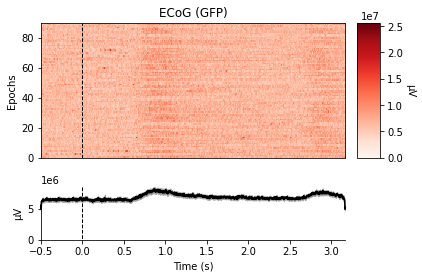

[<Figure size 432x288 with 3 Axes>]

In [ ]:
filtered.plot_image()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer , MinMaxScaler
from sklearn.linear_model import LogisticRegression ,  SGDClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



 Using MNE/sklearn

In [ ]:
# Feature extractation for each epoch

# Declare feature variables
mean = []
amplitude = []
kurt = []
skew = []
std = []
rms = []
alpha = []
beta = []
theta = []
delta = []
gamma = []
rel_b_a = []
rel_b_t =[]
rel_b_d = []
rel_a_t = []




In [ ]:
#For each epoch in the data compute the features

for i in filtered.get_data():
   mean.append(np.mean(i))
   kurt.append(np.mean(stats.kurtosis(i , axis = None)))
   skew.append(np.mean(stats.skew(i , axis = None)))
   std.append(np.std(i))
   gradient.append(np.mean(np.gradient(i)))
   rms.append(np.sqrt(np.mean(np.power(i, 2))))
   alpha.append(band_power(np.mean(i , axis = 0), 1200 , [8 , 12] , 'multitaper'))
   beta.append(band_power(np.mean(i , axis = 0), 1200 , [12,30] , 'multitaper'))
   theta.append(band_power(np.mean(i , axis = 0), 1200 , [4,8] , 'multitaper'))
   delta.append(band_power(np.mean(i , axis = 0), 1200 , [0.5,4] , 'multitaper'))
   gamma.append(band_power(np.mean(i , axis = 0), 1200 , [31 , 100] , 'multitaper'))
rel_b_a =[i / j for i, j in zip(beta , alpha)]
rel_b_t =[i / j for i, j in zip(beta , theta)]
rel_b_d =[i / j for i, j in zip(beta , delta)]
rel_a_t=[i / j for i, j in zip(alpha , theta)]

In [ ]:
#DataFrame of features from the Ecog
Ecog_feature_df = pd.DataFrame([mean , kurt , skew, std, rms, gradient, alpha, beta, theta, delta, gamma , rel_b_a, 
                    rel_b_t, rel_b_d , rel_a_t]).transpose()

In [ ]:
# Fingers features

f_mean = np.mean(fingers_data, axis = 2)
f_std  = np.std(fingers_data, axis = 2)
f_skew = stats.skew(fingers_data, axis = 2)
f_kurt = stats.kurtosis(fingers_data, axis = 2)

#Dataframe of feature from the Ecog
Finger_features_df = pd.DataFrame(np.hstack(( f_mean , f_std , f_skew, f_kurt)))

In [ ]:
 # Combining both Ecog and finger dataframes
complete_feature_matrix = pd.concat([Ecog_feature_df, Finger_features_df], axis=1)

In [ ]:
complete_feature_matrix.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-3.475186e-15,2.842090,-0.000555,7.433452,7.433452,-0.000354,6.771407e-30,5.674558e-29,7.374566e-30,5.235001e-30,5.678419e-25,8.380176,7.694769,10.839650,0.918211,0.368268,0.107208,0.124387,0.422699,0.129584,0.096246,0.096862,0.071857,0.174257,0.105765,0.331731,0.172321,-0.005135,-0.235961,0.135685,-1.358089,-1.892276,-1.689561,-1.469055,-1.806422
1,-3.318477e-15,2.598175,0.000375,7.316954,7.316954,-0.000553,9.284566e-30,1.230645e-28,1.635210e-29,1.139100e-29,6.239770e-25,13.254745,7.525916,10.803664,0.567790,0.532749,0.465594,0.335699,0.626907,0.470797,0.043262,0.425505,0.284445,0.316975,0.435001,-0.669600,0.183121,0.193091,0.100964,0.221489,-0.927411,-1.870435,-1.859992,-1.929897,-1.871111
2,1.538352e-15,4.990165,-0.035584,6.730267,6.730267,-0.000803,2.529520e-29,1.300736e-28,1.624780e-29,2.147431e-29,4.905202e-25,5.142226,8.005616,6.057173,1.556839,0.676228,0.036979,0.057634,0.252702,0.032254,0.004656,0.001852,0.007119,0.006093,0.005194,0.576213,0.784644,0.089917,-1.016030,-0.406004,1.522100,0.296091,-1.195143,-0.726076,-0.210679
3,-1.431690e-15,2.761185,-0.025055,7.380712,7.380712,-0.000674,4.155906e-29,2.988649e-28,3.579387e-29,3.416927e-29,7.549266e-25,7.191328,8.349609,8.746599,1.161066,0.454039,0.079457,0.103720,0.644495,0.369885,0.171062,0.043034,0.047132,0.342891,0.278420,0.472675,-0.098083,-0.145906,-0.250711,-0.177883,-1.703808,-1.802249,-1.582397,-1.901087,-1.862696
4,-4.015206e-15,6.239900,-0.148956,7.728221,7.728221,0.000098,2.817307e-29,1.154726e-28,2.691397e-29,1.758113e-29,5.873843e-25,4.098687,4.290433,6.567983,1.046782,0.399100,0.068213,0.082566,0.613823,0.407954,0.112131,0.037428,0.022775,0.320691,0.195036,0.262726,-0.024405,-0.483934,-0.097641,-0.027054,-1.838394,-1.780540,-0.549973,-1.897573,-1.829349
5,-7.896512e-16,2.995929,-0.021125,6.634724,6.634724,0.000043,2.323270e-29,1.963681e-28,3.423849e-29,2.139976e-29,5.976355e-25,8.452226,5.735301,9.176182,0.678555,0.497466,0.025817,0.068265,0.195877,0.072428,0.005810,0.002403,0.008431,0.011286,0.020802,-0.911605,-1.493583,1.175029,0.768678,1.869542,0.554771,1.687866,-0.012331,-0.578996,1.798845
6,-5.345811e-15,2.444294,0.005630,6.872793,6.872793,-0.000412,7.673394e-29,4.176225e-28,7.564299e-29,5.598121e-29,7.686448e-25,5.442474,5.520967,7.460047,1.014422,0.501017,0.018930,0.026838,0.157428,0.052064,0.060422,0.003031,0.008831,0.001331,0.001511,-0.991770,0.433797,0.178063,0.007740,-0.374053,-0.689333,-1.374653,-0.181119,0.614005,-0.204832
7,7.135370e-15,2.468043,-0.040668,7.306729,7.306729,0.000224,8.266807e-29,5.407517e-28,1.146827e-28,7.994058e-29,7.742036e-25,6.541240,4.715198,6.764420,0.720842,0.343027,0.041451,0.059082,0.573379,0.270279,0.084809,0.025463,0.038562,0.385614,0.206400,1.706436,0.488915,-0.332126,-0.071441,0.036837,3.165224,-0.361741,-1.779522,-1.951388,-1.891183
8,-1.195663e-15,2.133794,-0.006469,6.345539,6.345539,0.000168,4.218058e-29,2.054720e-28,3.627494e-29,2.827010e-29,7.009258e-25,4.871245,5.664295,7.268172,1.162802,0.705770,0.012182,0.033284,0.178408,0.067386,0.011535,0.003645,0.020516,0.002865,0.005307,-0.711890,-0.486507,0.668426,-0.892235,-1.099291,-1.109593,-1.228767,-1.417580,-0.417315,-0.349094
9,-5.884317e-15,2.930457,-0.037364,7.283794,7.283794,-0.000454,3.070537e-29,1.086381e-28,3.103086e-29,2.946105e-29,5.887497e-25,3.538081,3.500970,3.687516,0.989511,0.421991,0.589920,0.420874,0.628991,0.543957,0.223801,0.461346,0.337220,0.380013,0.425988,0.482161,-0.321970,-0.211272,-0.280254,-0.135355,-1.658824,-1.816663,-1.849607,-1.871316,-1.912357


## Training and Test data split

In [ ]:
#Splitting into X_train and Y train
x_train, x_test, y_train, y_test = train_test_split(complete_feature_matrix, np.array(ecog_label), test_size = 0.15, shuffle=True, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(complete_feature_matrix, np.array(ecog_label), test_size = 0.15, shuffle=True, random_state=33)
x_train, x_test, y_train, y_test = train_test_split(complete_feature_matrix, np.array(ecog_label), test_size = 0.3, shuffle=True, random_state=33)
x_train, x_test, y_train, y_test = train_test_split(complete_feature_matrix, np.array(ecog_label), test_size = 0.5, shuffle=True, random_state=333)

#Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train , y_train)
training_accuracy , _ = compute_accuracy(x_train , y_train , logreg)
print(f"Accuracy on the training data: {training_accuracy: .2%}")
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train) 

Accuracy on the training data:  100.00%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
# testing the model
test_accuracy , prediction = compute_accuracy(x_test , y_test , pipe)
print(f"Accuracy on the  test data: {test_accuracy: .2%}")

Accuracy on the  test data:  97.78%


In [ ]:
print(list(zip(prediction , y_test)))

[(3.0, 3.0), (2.0, 2.0), (1.0, 1.0), (1.0, 1.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (1.0, 1.0), (2.0, 2.0), (3.0, 3.0), (2.0, 2.0), (1.0, 1.0), (3.0, 3.0), (3.0, 3.0), (2.0, 2.0), (3.0, 3.0), (1.0, 1.0), (2.0, 2.0), (1.0, 1.0), (2.0, 2.0), (2.0, 2.0), (3.0, 3.0), (1.0, 1.0), (1.0, 1.0), (2.0, 2.0), (1.0, 1.0), (3.0, 3.0), (1.0, 1.0), (2.0, 2.0), (1.0, 1.0), (1.0, 1.0), (2.0, 2.0), (3.0, 3.0), (1.0, 1.0), (2.0, 2.0), (1.0, 1.0), (2.0, 2.0), (2.0, 2.0), (1.0, 1.0), (1.0, 1.0), (3.0, 3.0), (3.0, 3.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0)]


In [ ]:
pipe.predict_log_proba(x_test)

array([[-6.09515565e+00, -4.98416278e+00, -9.14091731e-03],
       [-3.12970313e+00, -6.16980207e-02, -4.12878275e+00],
       [-8.18135072e-03, -4.94738135e+00, -6.86278925e+00],
       [-1.65300303e-02, -4.24103864e+00, -6.21384650e+00],
       [-7.43690089e+00, -4.97352726e+00, -7.53613443e-03],
       [-7.06447752e+00, -4.80899971e+00, -9.05179972e-03],
       [-5.67464363e+00, -3.72778715e+00, -2.78624573e-02],
       [-9.35234226e-03, -4.72423017e+00, -7.74893933e+00],
       [-5.29134163e+00, -9.32866366e-03, -5.46076899e+00],
       [-5.37527045e+00, -5.22936295e+00, -1.00368040e-02],
       [-2.90321318e+00, -9.75192452e-02, -3.26837044e+00],
       [-8.98967637e-03, -4.83137847e+00, -6.93423239e+00],
       [-5.79480213e+00, -4.56418661e+00, -1.35531124e-02],
       [-6.58189520e+00, -4.97442936e+00, -8.33230126e-03],
       [-4.25836301e+00, -2.00235905e-02, -5.17097829e+00],
       [-6.33636881e+00, -5.17780951e+00, -7.43866682e-03],
       [-1.36908514e-02, -4.36772483e+00

#SGD classifier

In [ ]:
sgd_clf = SGDClassifier(random_state = 23 , max_iter = 100000 , eta0 = 0.9)
sgd_clf.fit(x_train, y_train)
training_accuracy , _ = compute_accuracy(x_train , y_train , sgd_clf)
print(f"Accuracy on the training data: {training_accuracy: .2%}")

Accuracy on the training data:  95.56%


In [ ]:
# testing the model
test_accuracy , _ = compute_accuracy(x_test , y_test , sgd_clf)
print(f"Accuracy on the  test data: {test_accuracy: .2%}")

Accuracy on the  test data:  91.11%


In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel="poly", degree= 2,   random_state = 42)

svc.fit(x_train , y_train)

training_accuracy, _= compute_accuracy(x_train , y_train ,svc)
print(f"Accuracy on the training data: {training_accuracy: .2%}")
test_accuracy , _110 = compute_accuracy(x_test , y_test , svc)
print(f"Accuracy on the  test data: {test_accuracy: .2%}")

Accuracy on the training data:  86.67%
Accuracy on the  test data:  80.00%
